In [1]:
import dgl
from Datasets.NodeClassification.Citeseer import Citeseer
from GraphSummarizers.Coarsener.HeteroCoarsener import HeteroCoarsener
import torch
import numpy as np

/home/robin/uu/thesis/convolution-matching/.venvconv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = Citeseer() 
original_graph = dataset.load_graph()


  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:

coarsener = HeteroCoarsener(None,original_graph, 0.5, num_nearest_per_etype=30, num_nearest_neighbors=30,pairs_per_level=10)
coarsener.init_step()

_create_h_spatial_rgcn 1.9608392715454102
stop init costs 1.016810417175293
_get_union 0.18426108360290527
_add_costs 2.944655418395996
_costs_of_merges 26.846095323562622
_init_merge_graph 0.00423121452331543
_find_lowest_cost_edges 0.0028839111328125


In [ ]:
coarsener.r = 0.5

In [19]:
isNewMerges = True
for i in range(100):
    if not isNewMerges:
        break
    print("--------- step: " , i , "---------" )
    isNewMerges = coarsener.iteration_step()
    

--------- step:  0 ---------
_merge_nodes 0.08666396141052246
_update_merge_graph_nodes_edges 0.09316039085388184
_update_merge_graph_edge_weigths_features 0.003573179244995117
candidates time 0.013262271881103516
_update_merge_graph_edge_weights_H 1.2691690921783447
_update_merge_graph 1.3851609230041504
_find_lowest_cost_edges 0.0020034313201904297
--------- step:  1 ---------
_merge_nodes 0.057775259017944336
_update_merge_graph_nodes_edges 0.10001254081726074
_update_merge_graph_edge_weigths_features 0.0020377635955810547
candidates time 0.011766910552978516
_update_merge_graph_edge_weights_H 0.9813051223754883
_update_merge_graph 1.1011860370635986
_find_lowest_cost_edges 0.0027413368225097656
--------- step:  2 ---------
_merge_nodes 0.058043479919433594
_update_merge_graph_nodes_edges 0.09904599189758301
_update_merge_graph_edge_weigths_features 0.002324342727661133
candidates time 0.012491703033447266
_update_merge_graph_edge_weights_H 1.0839622020721436
_update_merge_graph 1.2

In [20]:
coarsend_graph = coarsener.get_coarsend_graph()

mapping = coarsener.get_mapping("paper")
labels = coarsener._get_labels(mapping, "paper")
coarsend_graph.nodes["paper"].data["label"] = torch.tensor([labels[i] for i in range(len(labels))])


In [21]:
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 

ratio 0.49864743011722273


In [23]:
# 2. Utility: create train/val/test indices and corresponding labels

def get_splits_and_labels(hetero_graph, ntype='paper',train_ratio=0.1, val_ratio=0.1, test_ratio=0.8, random_state=42):
    """
    Extract train/val/test node indices and their labels for a given node type.

    Returns
    -------
    dict
        {
          'train_idx': LongTensor,
          'val_idx': LongTensor,
          'test_idx': LongTensor,
          'train_labels': LongTensor,
          'val_labels': LongTensor,
          'test_labels': LongTensor
        }
    """
    np.random.seed(random_state)
    indices = np.random.permutation(hetero_graph.nodes[ntype].data["feat"].size()[0])
    num_papers =hetero_graph.nodes[ntype].data["feat"].size()[0]
    
    train_size = int(num_papers * train_ratio)
    val_size = int(num_papers * val_ratio)
    
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    train_mask = torch.zeros(num_papers, dtype=torch.bool)
    val_mask = torch.zeros(num_papers, dtype=torch.bool)
    test_mask = torch.zeros(num_papers, dtype=torch.bool)
    
    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True
    
    # Add masks to hetero_data
    hetero_graph.nodes[ntype].data["train_mask"] = train_mask
    hetero_graph.nodes[ntype].data["val_mask"] = val_mask
    hetero_graph.nodes[ntype].data["test_mask"] = test_mask
    
    labels = hetero_graph.nodes[ntype].data['label']
    train_mask = hetero_graph.nodes[ntype].data['train_mask']
    val_mask = hetero_graph.nodes[ntype].data['val_mask']
    test_mask = hetero_graph.nodes[ntype].data['test_mask']

    train_idx = train_mask.nonzero(as_tuple=True)[0]
    val_idx = val_mask.nonzero(as_tuple=True)[0]
    test_idx = test_mask.nonzero(as_tuple=True)[0]

    return {
        'train_idx': train_idx,
        'val_idx': val_idx,
        'test_idx': test_idx,
        'train_labels': labels[train_idx],
        'val_labels': labels[val_idx],
        'test_labels': labels[test_idx]
    }

# Example usage:
data_splits_orig = get_splits_and_labels(original_graph)

In [24]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.data import CiteseerGraphDataset
from sklearn.decomposition import PCA
from dgl.nn import HeteroGraphConv, GraphConv

In [25]:
class HeteroGCN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, rel_names):
        super().__init__()
        # conv1: in_dim -> hidden_dim for each relation
        self.conv1 = HeteroGraphConv({
            rel: GraphConv(in_dim, hidden_dim)
            for rel in rel_names
        }, aggregate='sum')
        # conv2: hidden_dim -> out_dim for each relation
        self.conv2 = HeteroGraphConv({
            rel: GraphConv(hidden_dim, out_dim)
            for rel in rel_names
        }, aggregate='sum')

    def forward(self, graph, x_dict):
        # x_dict: {'paper': feature_tensor}
        h_dict = self.conv1(graph, x_dict)
        # apply activation
        h_dict = {ntype: F.relu(h) for ntype, h in h_dict.items()}
        h_dict = self.conv2(graph, h_dict)
        return h_dict

Epoch 1:
  Original Graph - Loss: 1.7975, Accuracy: 0.3373
  Coarsened Graph - Loss: 1.7906, Accuracy: 0.3212
  Inverted Coarsened - Accuracy: 0.2462

Epoch 11:
  Original Graph - Loss: 1.6912, Accuracy: 0.5060
  Coarsened Graph - Loss: 1.6662, Accuracy: 0.4606
  Inverted Coarsened - Accuracy: 0.4079

Epoch 21:
  Original Graph - Loss: 1.5562, Accuracy: 0.6114
  Coarsened Graph - Loss: 1.4942, Accuracy: 0.5333
  Inverted Coarsened - Accuracy: 0.5564

Epoch 31:
  Original Graph - Loss: 1.3620, Accuracy: 0.6566
  Coarsened Graph - Loss: 1.2561, Accuracy: 0.5455
  Inverted Coarsened - Accuracy: 0.6130

Epoch 41:
  Original Graph - Loss: 1.1415, Accuracy: 0.6837
  Coarsened Graph - Loss: 1.0114, Accuracy: 0.5515
  Inverted Coarsened - Accuracy: 0.6336

Epoch 51:
  Original Graph - Loss: 0.9418, Accuracy: 0.7078
  Coarsened Graph - Loss: 0.8116, Accuracy: 0.6000
  Inverted Coarsened - Accuracy: 0.6560

Epoch 61:
  Original Graph - Loss: 0.7883, Accuracy: 0.7199
  Coarsened Graph - Loss: 0.6

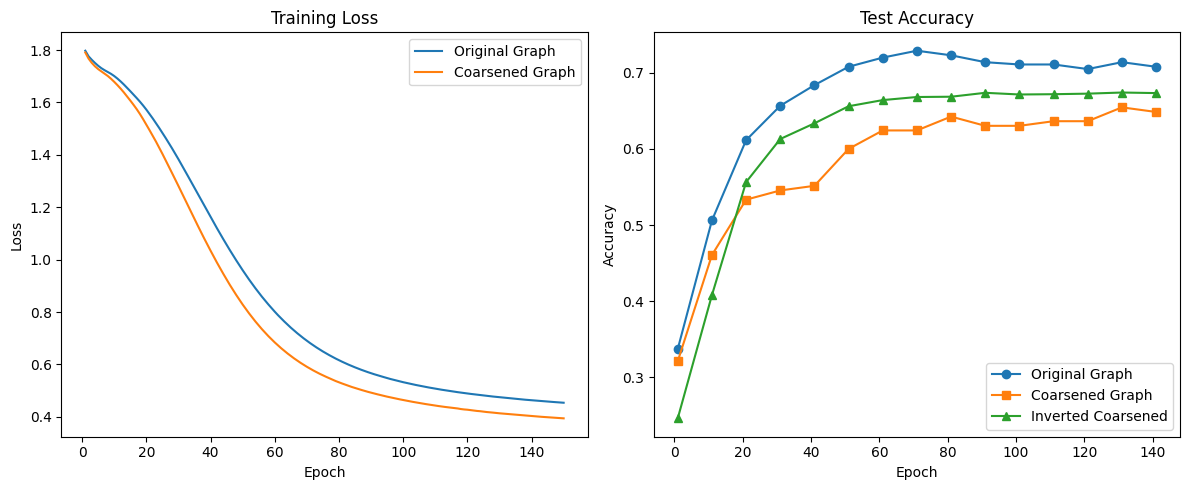

Final Performance Comparison:
Original Graph Accuracy: 0.7078
Coarsened Graph Accuracy: 0.6485
Inverted Coarsened Accuracy: 0.6733


In [26]:
# Import necessary libraries (if not already imported)
import torch
import torch.nn.functional as F
import numpy as np
from Models.GNNs.HGCN import ImprovedHeteroGNN

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_original = HeteroGCN(in_dim=original_graph.nodes["paper"].data["feat"].shape[1], hidden_dim=64,
                  out_dim=6, rel_names=original_graph.etypes)


feat_orig = {'paper': original_graph.nodes['paper'].data['feat']}

# Use our splits utility
data_splits_orig = get_splits_and_labels(original_graph)
train_idx_orig = data_splits_orig['train_idx']
val_idx_orig = data_splits_orig['val_idx']
test_idx_orig = data_splits_orig['test_idx']
labels_orig = original_graph.nodes['paper'].data['label']

optimizer_original = torch.optim.Adam(model_original.parameters(), lr=0.01, weight_decay=5e-4)



model_coarsened = HeteroGCN(in_dim=coarsend_graph.nodes["paper"].data["feat"].shape[1], hidden_dim=64,
                  out_dim=6, rel_names=original_graph.etypes)


feat_coar = {'paper': coarsend_graph.nodes['paper'].data['feat']}

# Use our splits utility
data_splits_coar = get_splits_and_labels(coarsend_graph)
train_idx_coar = data_splits_coar['train_idx']
val_idx_coar = data_splits_coar['val_idx']
test_idx_coar = data_splits_coar['test_idx']
labels_coar = coarsend_graph.nodes['paper'].data['label']

optimizer_coarsened = torch.optim.Adam(model_coarsened.parameters(), lr=0.01, weight_decay=5e-4)





target_node_type = "paper"



# Function to apply inversion mapping from coarsened to original
def apply_inversion_mapping(coarsened_pred, inversion_map, original_labels, test_mask):
    """
    Maps predictions from coarsened graph back to original graph nodes
    
    Args:
        coarsened_pred: Predictions on coarsened graph
        inversion_map: Mapping from coarsened nodes to original nodes
        original_labels: Ground truth labels of original graph
        
    Returns:
        mapped_accuracy: Accuracy after applying inversion mapping
    """
    correct_count = 0
    total_count = 0
    
    for orig_node, coarsened_node in inversion_map.items():
        if not coarsened_node in test_mask:
            continue
        coarse_pred = coarsened_pred[coarsened_node]
        orig_label = original_labels[orig_node]
        #print(coarse_pred, orig_label)

        correct = (coarse_pred == orig_label)
    
                
        if correct:
            correct_count += 1
     #   else:
      #      print(f"Mismatch: Coarsened Node {coarsened_node} predicted {coarse_pred}, Original Node {orig_node} label {orig_label}")
        total_count += 1
    
    return correct_count / total_count if total_count > 0 else 0

# Training function for original graph
def train_original():
    model_original.train()
    optimizer_original.zero_grad()
    
    #print(original_x_original_data.edge_index_dict)
    logits = model_original(original_graph, feat_orig)['paper']
    loss = F.cross_entropy(logits[train_idx_orig], labels_orig[train_idx_orig])
    loss.backward()
    optimizer_original.step()
    return loss.item()

# Training function for coarsened graph
def train_coarsened():
    model_coarsened.train()
    optimizer_coarsened.zero_grad()
    logits = model_coarsened(coarsend_graph, feat_coar)["paper"]
    loss = F.cross_entropy(logits[train_idx_coar], labels_coar[train_idx_coar])
    
    loss.backward()
    optimizer_coarsened.step()
    return loss.item()

    
# Evaluation function for original graph
def test_original():
    model_original.eval()
    with torch.no_grad():
        logits = model_original(original_graph, feat_orig)
        pred = logits[target_node_type].argmax(dim=1)
        
        # Calculate accuracy on test set
        correct = (pred[val_idx_orig] == labels_orig[val_idx_orig]).sum().item()
        return correct / val_idx_orig.shape[0]

# Evaluation function for coarsened graph
def test_coarsened():
    model_coarsened.eval()
    with torch.no_grad():
        logits = model_original(coarsend_graph, feat_coar)
        pred = logits[target_node_type].argmax(dim=1)
        
        # Calculate accuracy on test set
        correct = (pred[val_idx_coar] == labels_coar[val_idx_coar]).sum().item()
        coarsened_acc =  correct / val_idx_coar.shape[0]
        inverted_acc = 0
        
        # Apply inversion mapping to evaluate how coarsened predictions map to original graph
        inverted_acc  = apply_inversion_mapping(
              pred,  
              mapping,
              original_graph.nodes[target_node_type].data["label"], 
              test_idx_coar
          )
        return coarsened_acc, inverted_acc

# Training for 50 epochs and comparing both models
results = {
    "epoch": [],
    "original_loss": [],
    "coarsened_loss": [],
    "original_acc": [],
    "coarsened_acc": [],
    "inverted_acc": []
}
epochs = 150
for epoch in range(epochs):
    # Train both models
    original_loss = train_original()
    coarsened_loss = train_coarsened()
    
    # Store results
    results["epoch"].append(epoch+1)
    results["original_loss"].append(original_loss)
    results["coarsened_loss"].append(coarsened_loss)
    
    # Evaluate every 10 epochs
    if epoch % 10 == 0:
        original_acc = test_original()
        coarsened_acc, inverted_acc = test_coarsened()
        results["original_acc"].append(original_acc)
        results["coarsened_acc"].append(coarsened_acc)
        results["inverted_acc"].append(inverted_acc)
        
        print(f'Epoch {epoch+1}:')
    
    
        print(f'  Original Graph - Loss: {original_loss:.4f}, Accuracy: {original_acc:.4f}')
        print(f'  Coarsened Graph - Loss: {coarsened_loss:.4f}, Accuracy: {coarsened_acc:.4f}')
        print(f'  Inverted Coarsened - Accuracy: {inverted_acc:.4f}')
        print()

# Visualization of results
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results["epoch"], results["original_loss"], label="Original Graph")
plt.plot(results["epoch"], results["coarsened_loss"], label="Coarsened Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
x = [results["epoch"][i] for i in range(0, epochs, 10)]
plt.plot(x, results["original_acc"], 'o-', label="Original Graph")
plt.plot(x, results["coarsened_acc"], 's-', label="Coarsened Graph")
plt.plot(x, results["inverted_acc"], '^-', label="Inverted Coarsened")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Final comparison
print("Final Performance Comparison:")
print(f"Original Graph Accuracy: {results['original_acc'][-1]:.4f}")
print(f"Coarsened Graph Accuracy: {results['coarsened_acc'][-1]:.4f}")
print(f"Inverted Coarsened Accuracy: {results['inverted_acc'][-1]:.4f}")

# Calculate speedup from using coarsened graph
# (You would need to time the training for a proper comparison)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import numpy as np
import random

# fix global seeds (we'll override per‐run below)
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

class GCN(torch.nn.Module):
    def __init__(self, in_feats, hidden_dim, out_feats, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_feats)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def run(seed):
    # reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # 1) Load Citeseer public split
    dataset = Planetoid(root='data/Citeseer', name='CiteSeer', split='public')
    data = dataset[0].to(device)

    # 2) Model & optimizer (Table 6 hyperparams)
    model = GCN(
        in_feats   = dataset.num_features,
        hidden_dim = 256,
        out_feats  = dataset.num_classes,
        dropout    = 0.5
    ).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-2,
        weight_decay=5e-4
    )

    best_val_acc = 0.0
    test_acc_at_best = 0.0

    # 3) Training with early stopping by validation
    for epoch in range(1, 501):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        logits = model(data.x, data.edge_index)
        preds = logits.argmax(dim=1)

        train_acc = (preds[data.train_mask] == data.y[data.train_mask]).float().mean()
        val_acc   = (preds[data.val_mask]   == data.y[data.val_mask]).float().mean()
        test_acc  = (preds[data.test_mask]  == data.y[data.test_mask]).float().mean()

        # track best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc_at_best = test_acc

    return test_acc_at_best.item()

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    seeds = [1, 2, 3, 4, 5]
    results = [run(s) for s in seeds]
    mean = np.mean(results)
    std  = np.std(results)
    print(f'Test accuracy over seeds {seeds}:')
    print([f'{r*100:.2f}%' for r in results])
    print(f'Mean ± std: {mean*100:.2f}% ± {std*100:.2f}%')


Test accuracy over seeds [1, 2, 3, 4, 5]:
['68.40%', '69.80%', '70.30%', '68.90%', '68.30%']
Mean ± std: 69.14% ± 0.79%
